In [1]:
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from croissant.healpix import grid2healpix
import faraday as fd

#%matplotlib notebook

## Spectral Response

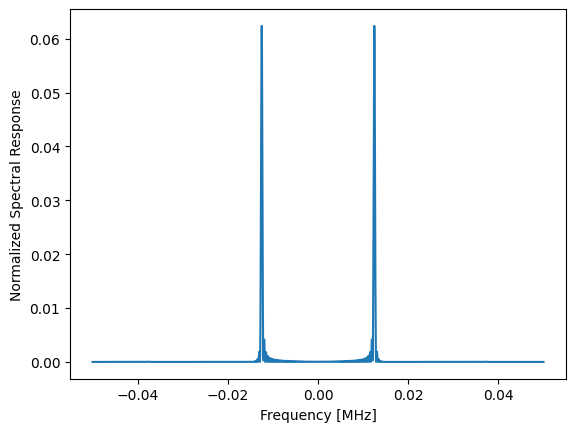

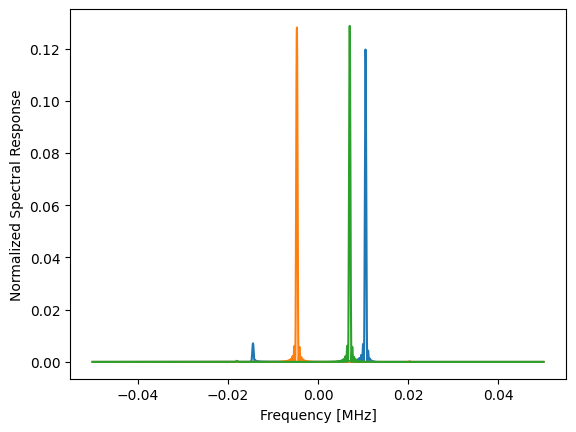

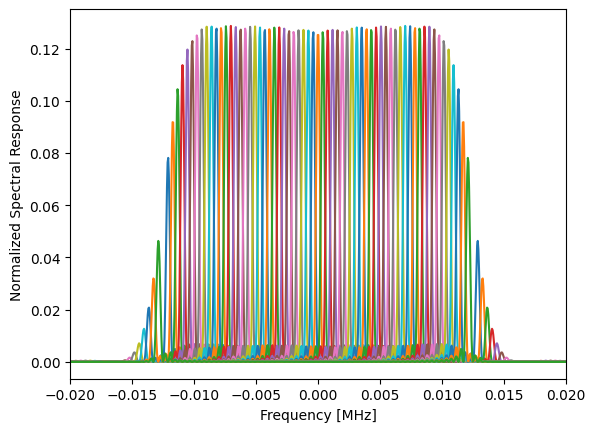

In [3]:
sim = fd.Simulator(None, None)

plt.figure()
plt.plot(sim.offset, sim.spec[:, 0])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Normalized Spectral Response")
plt.show()

plt.figure()
plt.plot(sim.offset, sim.spec[:, -5])
plt.plot(sim.offset, sim.spec[:, 20])
plt.plot(sim.offset, sim.spec[:, 50])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Normalized Spectral Response")
plt.show()

plt.figure()
plt.plot(sim.offset, sim.spec[:, 1:])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Normalized Spectral Response")
plt.xlim(-20/1e3, 20/1e3)
plt.show()

## Simulation Parameters and Constants

In [2]:
FREQ = 30  # minimum frequency in MHz
NCHANS = 64  # frequency channels
NSIDE = 128
THETA_MAX = 5  # extent of point src in degrees
RM = 250  # rotation measure

frequencies = np.linspace(0, 25/1e3, NCHANS) + FREQ  # 64 channels of 390 Hz width
c = 299792458  # m / s

# LuSEE Beam + Zenith Source

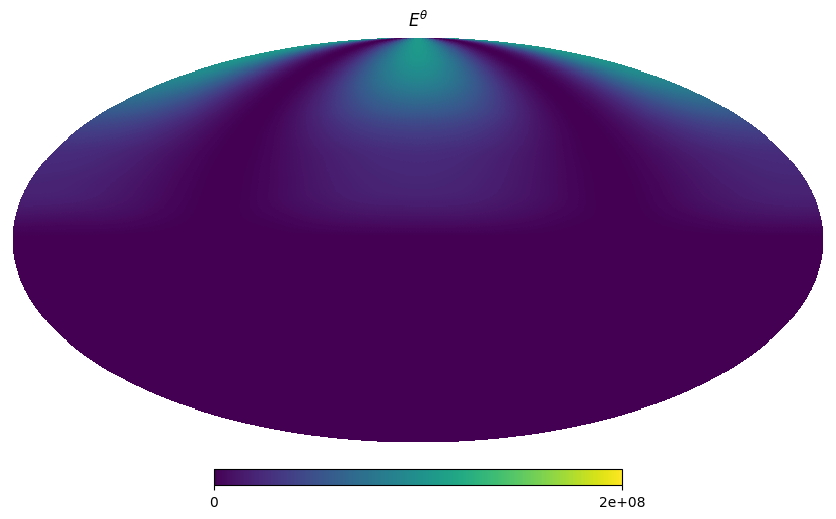

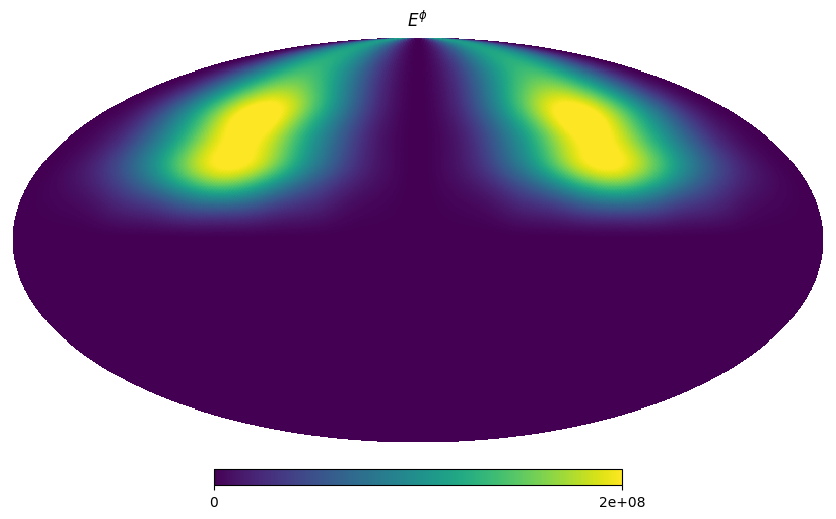

In [15]:
# lusee beam
def read_beam(fname, freq=FREQ):
    with fits.open(fname) as hdul:
        E_theta = hdul["Etheta_real"].data + 1j * hdul["Etheta_imag"].data
        E_phi = hdul["Ephi_real"].data + 1j * hdul["Ephi_imag"].data
        ix = np.argwhere(hdul["freq"].data == freq)[0, 0]
        E_theta = E_theta[ix]
        E_phi = E_phi[ix]

    lusee_Y = np.array([E_theta.real, E_theta.imag, E_phi.real, E_phi.imag])[:, :, :-1]
    lusee_Y = np.concatenate((lusee_Y, np.zeros_like(lusee_Y)[:, :-1, :]), axis=1)
    #lusee_Y /= np.abs(lusee_Y).max(axis=(1,2))[:, None, None]
    return lusee_Y
    
lusee_Y = read_beam("../data/hfss_lbl_3m_75deg.2port.fits")  # along Y axis
lusee_X = np.roll(lusee_Y, -90, axis=-1)
lusee_X = grid2healpix(lusee_X, NSIDE)
lusee_Y = grid2healpix(lusee_Y, NSIDE)

beam_X = np.array([lusee_X[0] + 1j * lusee_X[1], lusee_X[2] + 1j * lusee_X[3]])
beam_Y = np.array([lusee_Y[0] + 1j * lusee_Y[1], lusee_Y[2] + 1j * lusee_Y[3]])

beam = fd.Beam(beam_X=beam_X, beam_Y=beam_Y, frequency=FREQ)

hp.mollview(np.abs(beam.beam_X[0])**2, title="$E^{\\theta}$", min=0, max=2e8)
plt.show()
hp.mollview(np.abs(beam.beam_X[1])**2, title="$E^{\\phi}$", min=0, max=2e8)
plt.show()

In [16]:
frequencies = offset - offset[0] + FREQ

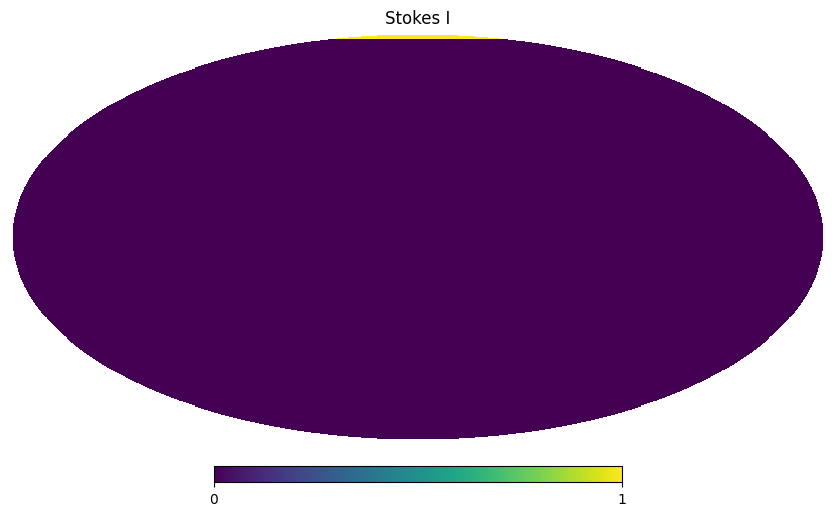

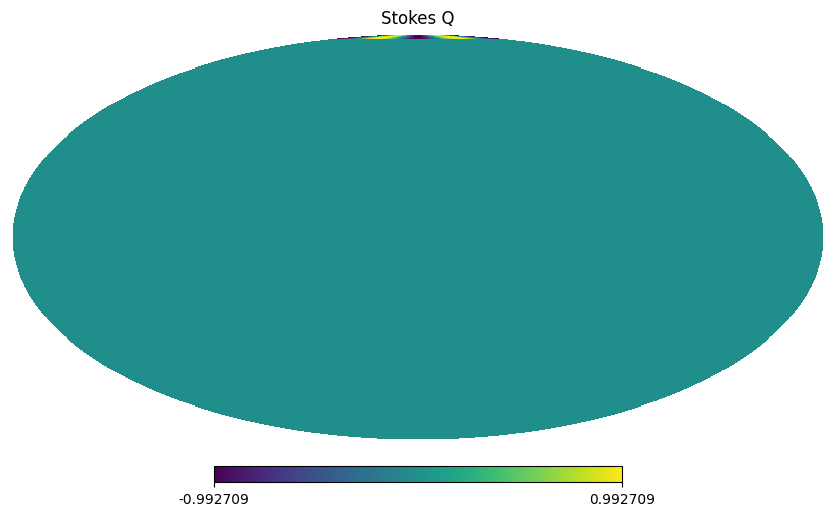

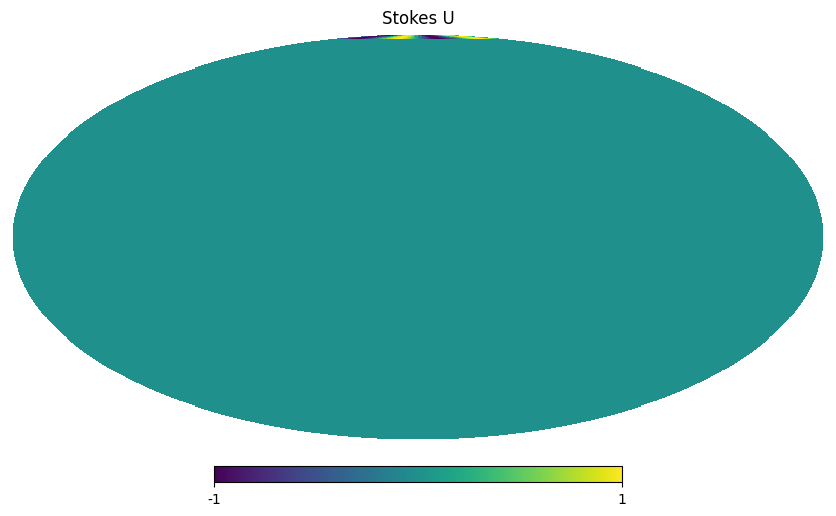

(1, 3, 196608)
(1, 3, 364)
(2000, 3, 364)


In [17]:
sky = fd.Sky.zeros(NSIDE, freq=FREQ)
sky.add_point_source(extent=THETA_MAX)  # 5 deg source at zenith
hp.mollview(sky.stokes[0, 0], title="Stokes I")
plt.show()
hp.mollview(sky.stokes[0, 1], title="Stokes Q")
plt.show()
hp.mollview(sky.stokes[0, 2], title="Stokes U")
plt.show()

print(sky.stokes.shape)
pix = sky.del_dark_pixels()  # pixels to keep
beam.del_pix(pix)
print(sky.stokes[..., sky.bright_pixels].shape)
sky.power_law(frequencies, -2.5)
print(sky.stokes.shape)

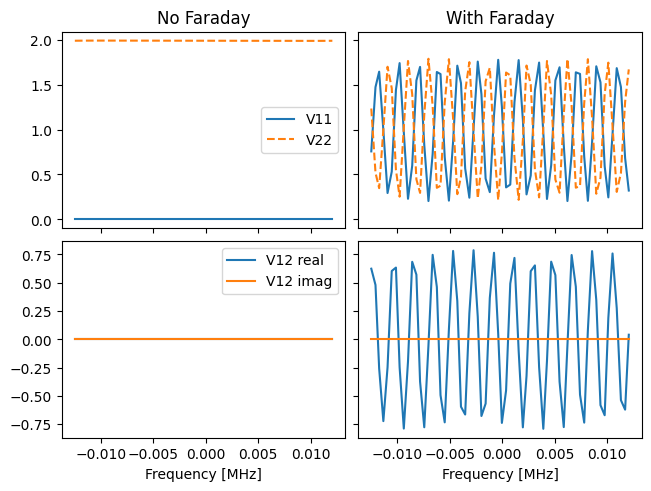

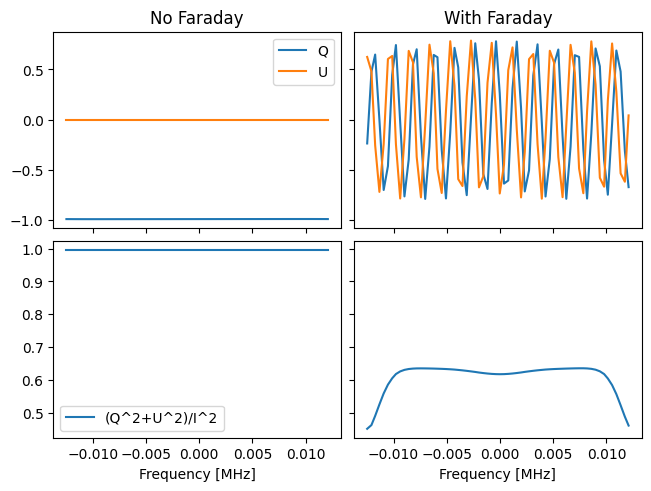

In [21]:
sky.apply_faraday(RM)
sim = fd.Simulator(beam, sky)
sim.run()
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot)
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

In [ ]:
a